# EE 519 — Speech AI 
## HW-1 | Notebook 2: Signal Operations & System Properties (Linearity + Time Invariance)

**Student Name:** Kobe Kodachi

**USC ID:**  7134744658

**Date:**  2/3/2026

---

### Learning Objectives
By completing this notebook, you will:
- Apply common **signal operations** (addition, scaling, multiplication) to speech
- Understand which operations are physically meaningful and which are not
- Test whether a system is **linear** and/or **time-invariant**
- Build intuition using **plots + listening tests + reasoning**

> ⚠️ **Important**
> - All answers (code + explanations) must be written **inside this notebook**
> - Do **not** delete questions or prompts
> - Clearly label all plots (title, axes, units)
> - Audio must be playable inline where requested


### Grading (Notebook 2 — 20 points)

| Component | Points |
|---|---:|
| Correct loading/handling of signals | 3 |
| Signal operations (addition/scaling/multiplication) + plots | 6 |
| Linearity tests (additivity + homogeneity) | 5 |
| Time invariance tests (delay-in / delay-out logic) | 4 |
| Clarity, organization, and clean reporting | 2 |

> We grade **understanding and reasoning**, not perfection.


---

# 0. Setup

This notebook must run **quickly and reproducibly** for grading.

## ✅ Reproducibility requirements (very important)
- Put all audio files in the **same folder as this notebook**, or inside `./audio/`.
- Use **relative paths only** (no absolute paths like `/Users/...` or `C:\...`).
- Do **not** rely on cloud-mounted paths (Google Drive mounts, etc.).
- Your notebook must run from top to bottom after we download your submission ZIP.

Recommended folder structure:
```
HW1/
├── HW1_Notebook2_Signal_Operations_and_System_Properties.ipynb
├── audio/
│   ├── x1.wav
│   └── x2.wav
└── (optional) utils.py
```

## Data requirements
You need **at least two** speech recordings:
- `x1`: your sentence (or a short phrase)
- `x2`: another recording (could be another sentence, another speaker, or a vowel/fricative)

### You have two options (choose one):
**Option A — Record inside Python (recommended if supported):**
- Record `x1` and `x2` directly in this notebook and save as WAV into `./audio/`

**Option B — Record externally and load:**
- Record using phone / laptop app, export as WAV, then place files in `./audio/`
- Keep filenames simple (no spaces)

Suggested filenames:
- `./audio/x1.wav`
- `./audio/x2.wav`

> If the two signals have different sampling rates or lengths, you must handle this properly and document what you did.


In [2]:
# TODO: Load required libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Optional: scipy for resampling
from scipy.signal import resample_poly


In [3]:
# TODO: Choose ONE of the two options below.

# =========================
# Option A (Optional): Record inside this notebook
# =========================
# If your environment supports recording, you may record and save WAV files to ./audio.
# After recording, set X1_PATH and X2_PATH to the saved files below.

# =========================
# Option B (Default): Load existing WAV files
# =========================
# Put your files here (recommended):
#   ./audio/x1.wav
#   ./audio/x2.wav

X1_PATH = "./audio/x1.wav"
X2_PATH = "./audio/x2.wav"


### Optional: Recording inside the notebook (if supported)

If you want to record directly in Python, you may use one of these approaches:
- **JupyterLab/Notebook with `sounddevice`** (works on some machines)
- **Google Colab** (requires special widgets; not guaranteed)
- Or record externally (Option B), which is always acceptable

> If recording inside Python does not work on your system, **use Option B**.


In [ ]:
# OPTIONAL (only if supported on your system):
# Record audio inside Python and save to ./audio
#
# If this doesn't work, skip it and use Option B (load external WAV files).

# !pip install sounddevice soundfile  # (uncomment if needed and allowed)
# import sounddevice as sd
# import soundfile as sf
# from pathlib import Path

# Path("./audio").mkdir(exist_ok=True)

# fs_rec = 16000
# duration_sec = 4

# print("Recording x1... Speak your sentence now.")
# x1 = sd.rec(int(duration_sec*fs_rec), samplerate=fs_rec, channels=1)
# sd.wait()
# x1 = x1.squeeze()
# sf.write("./audio/x1.wav", x1, fs_rec)

# print("Recording x2... Record a different utterance now.")
# x2 = sd.rec(int(duration_sec*fs_rec), samplerate=fs_rec, channels=1)
# sd.wait()
# x2 = x2.squeeze()
# sf.write("./audio/x2.wav", x2, fs_rec)

# After recording, keep:
# X1_PATH = "./audio/x1.wav"
# X2_PATH = "./audio/x2.wav"


In [5]:
# TODO: Implement or reuse your WAV loader from Notebook 1
import os
from scipy.io import wavfile

def to_mono(x):
    """Ensure mono float32 in [-1, 1]."""
    x = np.asarray(x)
    if x.ndim == 2:  # stereo -> mono
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def load_wav(path):
    """Return mono float32 signal in [-1, 1] and sampling rate fs."""
    if not os.path.exists(path):
        # print(f"File not found: {path}\nUpload a WAV and update wav_path.")
        raise FileNotFoundError(f"File not found: {path}")
    else:
        fs, x = wavfile.read(path)
        x = to_mono(x)
        print("Loaded:", path)
        print("Sampling rate (Hz):", fs)
        print("Duration (s):", len(x)/fs)
        print(f"Min/max amplitude: {x.min():.3f}/{x.max():.3f}")
        return x, fs


In [6]:
# TODO: Load both signals
x1, fs1 = load_wav(X1_PATH)
x2, fs2 = load_wav(X2_PATH)

# Print:
# - fs, duration, min/max for each


Loaded: ./audio/x1.wav
Sampling rate (Hz): 16000
Duration (s): 4.0
Min/max amplitude: -0.648/1.000
Loaded: ./audio/x2.wav
Sampling rate (Hz): 16000
Duration (s): 4.0
Min/max amplitude: -0.633/1.000


In [7]:
# TODO: Utility helpers (plotting and playback)
def plot_waveform(x, fs, title, tlim=None):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")    
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

def play_audio(x, fs):
    display(Audio(x, rate=fs))


---

# 1. Preprocessing for Fair Operations

Many operations (addition, multiplication) require:
- Same sampling rate
- Comparable signal lengths
- Proper alignment (optional but recommended)

### Task
Create `x1p` and `x2p` such that:
1. Both have the **same sampling rate** (choose one and explain)
2. Both have the **same length** (truncate or pad, but document)
3. Optional: Align signals (e.g., trim leading silence)

> You must clearly explain your design choices below.


In [13]:
# TODO: Choose a common sampling rate
# Option A: use fs1
# Option B: use fs2
# Option C: choose a new rate (e.g., 16000) and resample both

fs_common = 8000


In [8]:
# TODO: Implement resampling if needed
from math import gcd

def resample_signal(x, fs_in, fs_out):
    """Return resampled signal."""
    # raise NotImplementedError("Implement resample_signal")
    g = gcd(fs_in,fs_out)
    up = fs_out // g
    down = fs_in // g
    x_out = resample_poly(x,up,down)
    return x_out, fs_out


In [17]:
# TODO: Create preprocessed signals with same fs and same length
x1p, _ = resample_signal(x1,fs1,fs_common)
x2p, _ = resample_signal(x2,fs2,fs_common)
fs = fs_common

### Explain your preprocessing

- What sampling rate did you choose and why?
- How did you handle length mismatch?
- Did you align signals? If yes, how?


### Explanation

I chose 8k sampling rate because both signals were originally 16k. From the first notebook I knew that 8k still sounded decent so I chose the one with less memory impact. The length were both 4 seconds when I recorded them so I didn't have to change anything.

---

# 2. Signal Operations (Time + Frequency + Listening)

In this section, you will perform:
- Addition
- Amplitude scaling
- Multiplication

For each operation:
1. Plot waveform (full + zoom)
2. Plot magnitude spectrum (optional but strongly recommended)
3. Play audio (when meaningful)
4. Describe what you observe


In [18]:
# TODO: Implement a magnitude spectrum helper
def magnitude_spectrum(x, fs):
    """Return frequency axis (Hz) and magnitude spectrum (linear or dB)."""
    # raise NotImplementedError("Implement magnitude_spectrum")
    n = len(x)
    x_w = x * np.hanning(n).astype(np.float32)

    # compute fft and freq axis
    X = np.fft.rfft(x_w)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    mag = 20*np.log10(np.abs(X) + 1e-12)
    # mag = np.abs(X)

    return freqs, mag

def plot_spectrum(f, mag):
    plt.figure(figsize=(12, 4))
    plt.plot(f, mag, linewidth=1.0)
    plt.title("Magnitude vs Frequency")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.xlim(0, fs/2)
    plt.grid(True)
    plt.show()


## 2.1 Addition: x1 + x2

### Tasks
- Compute `y_add = x1p + x2p`
- Prevent clipping if needed (document your method)
- Compare `y_add` to originals

> Question: Is adding two speech signals physically meaningful? In what scenario might it be? (hint: mixing)


In [19]:
# TODO: Addition
# y_add = x1p + x2p
# If clipping occurs, apply a documented strategy:
# - normalize
# - scale by 0.5
# - limiter (not required)

# add and scale
y_add = 0.5 * (x1p + x2p)

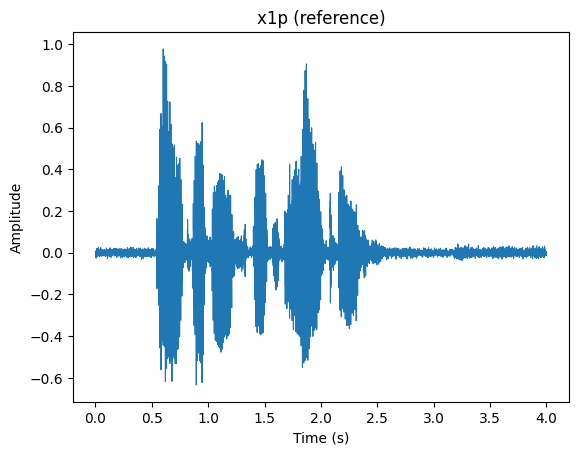

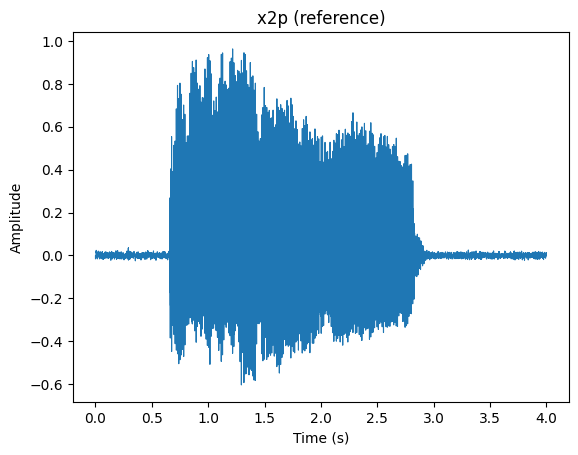

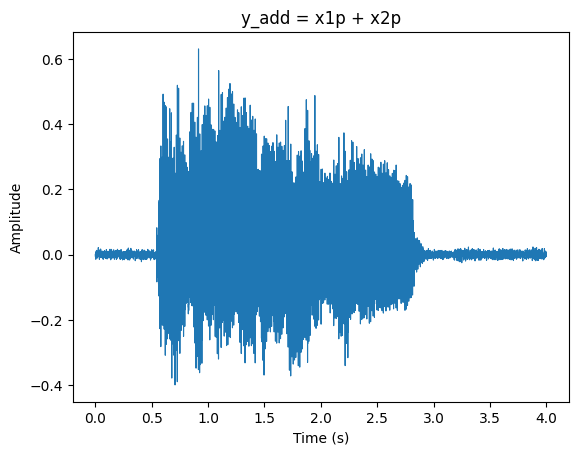

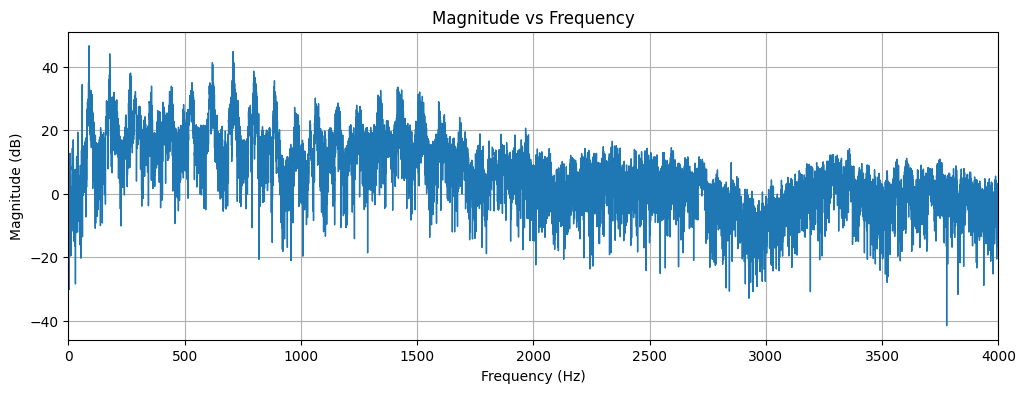

In [20]:
# TODO: Plot + play
plot_waveform(x1p, fs, "x1p (reference)")
plot_waveform(x2p, fs, "x2p (reference)")
plot_waveform(y_add, fs, "y_add = x1p + x2p")
f, m = magnitude_spectrum(y_add,fs)
plot_spectrum(f,m)
play_audio(y_add, fs)


### Observations (Addition)

- Does the result sound like a mixture?
- Is intelligibility reduced? Why?
- Did you observe clipping? If so, how did you fix it?


### Answers

The results does sound like a mixture. Intelligibility didn't degrade too much as I could still understand the sentence and vowels. I solved clipping by averaging the signals which reduced the amplitude.

## 2.2 Amplitude scaling: a·x

### Tasks
Pick at least 3 scaling factors (e.g., 0.25, 0.5, 2.0).
- Compute `y_scale = a * x1p`
- Listen and compare
- Plot waveforms (zoomed)

> Concept check: Is amplitude scaling the same as “volume change”?  
> Explain perceptually and technically.


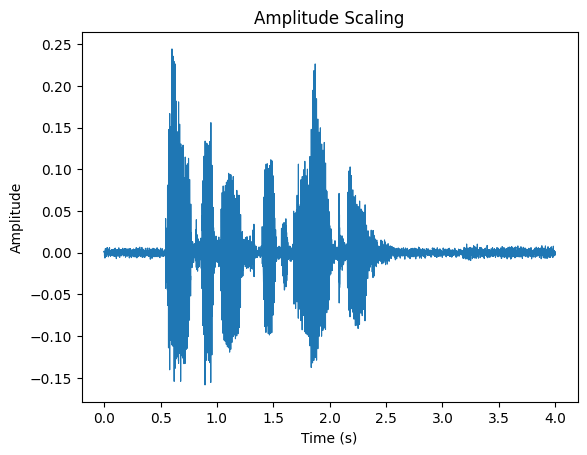

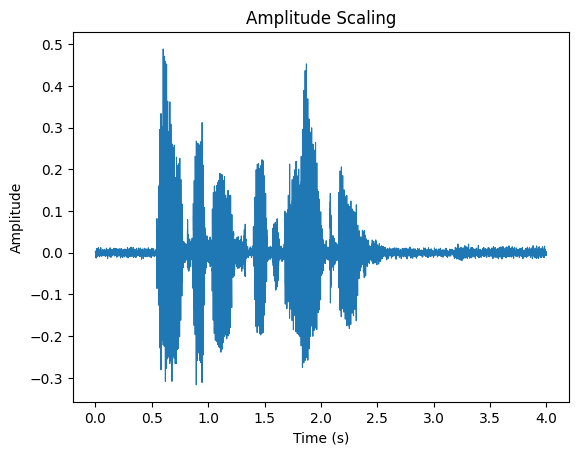

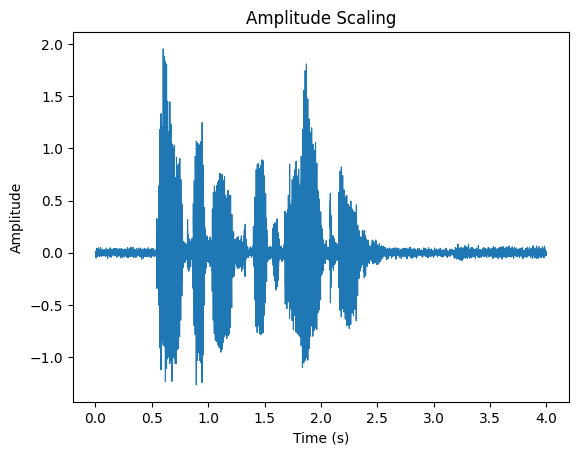

In [21]:
# TODO: Amplitude scaling experiments
scales = [0.25, 0.5, 2.0]
for a in scales:
    y = a * x1p
    play_audio(y,fs)
    plot_waveform(y,fs,"Amplitude Scaling")


### Observations (Scaling)

- At what scaling factor do you first observe clipping?
- Is doubling amplitude perceived as “twice as loud”? Why/why not?


### Answers
Technically it's the same but conceptually its not because perceived loudness depends on more than amplitude. It also depends on the duration and frequency.

We get clipping when the amplitude is outside the range [-1,1]. We see this with the 2.0 scale. As explained above doubling the amplitude is not twice as loud because other factors also effect perceived loudness.

## 2.3 Multiplication

### Task A: Speech × sine wave (AM-like effect)
- Generate a sine wave `s(t)` at a chosen frequency (e.g., 50–300 Hz)
- Compute `y_mul = x1p * s`

### Task B: Speech × speech
- Compute `y_ss = x1p * x2p`

For each:
- Plot waveform (zoom)
- Plot spectrum
- Listen and describe

> Hint: Multiplication in time corresponds to convolution in frequency (conceptual link).


In [22]:
# TODO: Create a sine wave with same length as x1p
f0 = 120
t = np.arange(len(x1p)) / fs
s = np.sin(2*np.pi*f0*t)


In [23]:
# TODO: Multiplication experiments
y_mul = x1p * s
y_ss = x1p * x2p


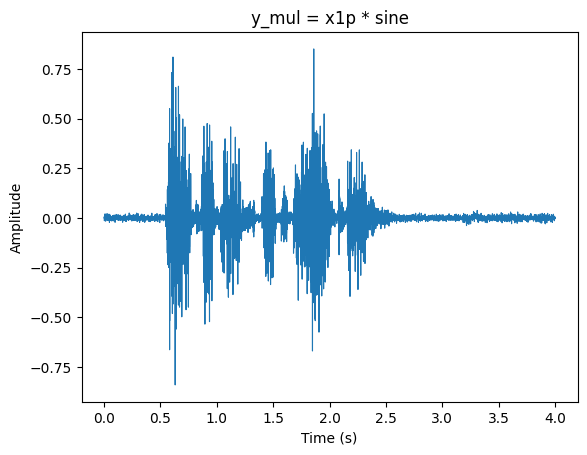

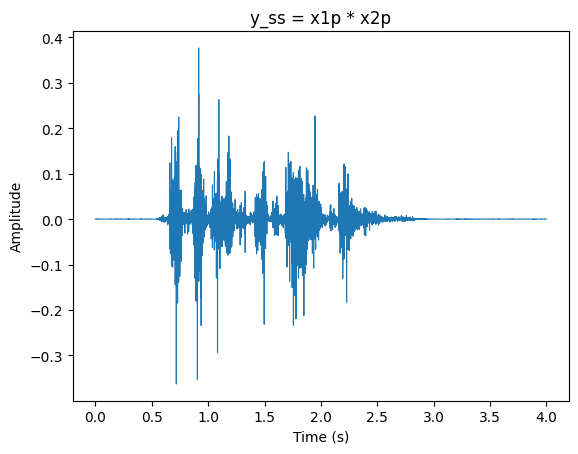

In [25]:
# TODO: Plot + play results
plot_waveform(y_mul, fs, "y_mul = x1p * sine")
play_audio(y_mul, fs)
plot_waveform(y_ss, fs, "y_ss = x1p * x2p")
play_audio(y_ss, fs)


### Observations (Multiplication)

- How does `speech × sine` sound compared to original speech?
- What happens to intelligibility in `speech × speech`?
- What changes do you see in the spectrum?


### Answers

The speech x sine sounds much more robotic than the original. The vowel sound is completely gone and the sentence part is much more robotic. It's still intellgible but much less so. The amplitude is significantly less because most values are less than 1 so we are multiplying fractions.

---

# 3. System Properties: Linearity

A system **T{·}** is linear if:
1. Additivity: T(x1 + x2) = T(x1) + T(x2)
2. Homogeneity: T(a·x) = a·T(x)

In this section, you will define **three** systems and test linearity:
- System 1 (linear candidate): e.g., gain + delay, moving average (FIR), convolution with fixed kernel
- System 2 (nonlinear): clipping, squaring, normalization by max
- System 3 (your choice): explain why you chose it


In [27]:
# TODO: Define three systems as Python functions T(x)
# Each should accept x (1D numpy array) and return y (same length preferred)
from scipy.signal import lfilter

def T1(x):
    """System 1: Moving average (FIR)"""
    kernel = np.array([1/3, 1/3, 1/3])
    y = lfilter(kernel, 1.0, x)
    return y

def T2(x):
    """System 2: Clipping violates nonlinearity"""
    return np.clip(x,-0.75,0.75)

def T3(x):
    """System 3: Squaring the input violates nonlinearity"""
    return x * x


## 3.1 Linearity Test Procedure

For each system T:
1. Choose two signals (use `x1p` and `x2p`)
2. Choose a scalar a (e.g., a = 0.7)
3. Compute:
   - Left_add = T(x1 + x2)
   - Right_add = T(x1) + T(x2)
   - Left_hom = T(a·x1)
   - Right_hom = a·T(x1)
4. Measure error:
   - e_add = ||Left_add - Right_add|| / ||Left_add||
   - e_hom = ||Left_hom - Right_hom|| / ||Left_hom||

### Deliverables
- A small table of errors for each system (additivity + homogeneity)
- A brief conclusion: linear / not linear (with evidence)


In [28]:
# TODO: Implement linearity tests and report errors
from numpy.linalg import norm

def rel_error(a, b, eps=1e-12):
    """Relative L2 error ||a-b||/||a||."""
    # raise NotImplementedError("Implement rel_error")
    return norm(a - b) / (norm(a) + eps)

alpha = 0.7  # you may change


In [33]:
# TODO: Run tests for T1, T2, T3
# Compute and print a clean summary

tests = [("T1",T1), ("T2",T2), ("T3",T3)]

for name, T in tests:
    print(f"{name} Results:")
    outputs = [
        T(x1p + x2p),
        T(x1p) + T(x2p),
        T(alpha * x1p),
        alpha * T(x1p)
    ]
    print(f"e_add: {rel_error(outputs[0],outputs[1]):.3f}")
    print(f"e_hom: {rel_error(outputs[2],outputs[3]):.3f}")


T1 Results:
e_add: 0.000
e_hom: 0.000
T2 Results:
e_add: 0.037
e_hom: 0.026
T3 Results:
e_add: 0.423
e_hom: 0.429


### Conceptual Questions (Linearity)

1. Which of your systems were linear? Which were not?  
2. Why does **clipping** break linearity? Explain using the definition.  
3. Is “normalizing by max amplitude” linear? Why or why not?


### Answers

1. T1 was linear as seen with the zero error for add and homogenity. The others had errors with T3 being the largest because we are squaring it.
2. Clipping breaks nonlinearity because we define min/max values. We can think of it similarly to the ReLU activation function.
3. It is nonlinear because it fails homogenity.

---

# 4. System Properties: Time Invariance

A system **T{·}** is time-invariant if shifting the input shifts the output by the same amount:
- If x₂(t) = x₁(t - t₀), then T{x₂}(t) = T{x₁}(t - t₀)

### Task
For each system (T1, T2, T3):
1. Create a delayed version of x1p by a fixed delay D samples
2. Compare:
   - yA = T(delay(x1p))
   - yB = delay(T(x1p))
3. Measure error and conclude time-invariant or not


In [32]:
# TODO: Implement delay (shift) operator
def delay_signal(x, D):
    """Delay by D samples (zero-pad at start, truncate end)."""
    # raise NotImplementedError("Implement delay_signal")
    y = np.zeros_like(x)
    y[D:] = x[:-D]
    return y

In [35]:
# TODO: Time invariance tests for each system
D = int(0.1*fs)  # choose a delay in samples, e.g., int(0.1*fs) for 100 ms

# For each T:
for name, T in tests:
    yA = T(delay_signal(x1p, D))
    yB = delay_signal(T(x1p), D)
# Compute relative error and interpret
    print(f"{name} Test:")
    print(f"Relative Error: f{rel_error(yA,yB)}")


T1 Test:
Relative Error: f0.0
T2 Test:
Relative Error: f0.0
T3 Test:
Relative Error: f0.0


### Observations & Interpretation (Time Invariance)

- Which systems appear time-invariant?
- If a system is nonlinear, can it still be time-invariant? Explain.
- Does clipping violate time invariance? Under what conditions might it *appear* time-invariant?


### Answers

All of the systems appear time-invariant. Nonlinear systems can still be time invariant as seen with the examples above. Each output only depends on the local time value. Since I chose a constant clipping value as opposed to something signal dependent it is time invariant.

---

# 5. Mini-Discussion: “Meaningful” vs “Not Meaningful” Operations

Write 8–12 lines:

- Which operations (addition, scaling, multiplication) are meaningful for audio/speech processing?
- Which ones produce artifacts that are not typical in real acoustic mixing?
- Give at least one real-world example where each meaningful operation occurs.


### Answers

Addition is useful as long as we are concious to avoid clipping since we can mix the signals. Scaling can be used to adjust the amplitude/volume as needed and would be useful in many audio processing situations. The multiplication will be less useful since it ruined the intelligibility. Maybe if we want to create a robotic voice changer but I don't see any applications outside of that. The addition and scaling didn't cause any artifacts but the multiplication added many. A real world example of addition would be adding background sounds to a music track. Scaling could be useful to normalize the amplitudes of multiple signals. Multiplication could be used when we want to produce the artifacts maybe for sound effects or editting purposes.

---

# 6. Reflection (Mandatory)

Write thoughtful answers (no right/wrong, but must be specific):

1. What did you learn about **signal operations** that you did not expect?  
2. What was one **surprising sound** you created (describe what caused it)?  
3. Which plot (time waveform vs spectrum) was more useful for explaining what you heard—and why?  
4. If you had to teach “linearity” to a friend in 2–3 sentences using one of your systems, what would you say?  
5. What is one experiment you wish you had time to try next?


### Answers

1. I did not expect overlaying two audio signals to be as intuitive as adding them together. I also didn't expect multiplication to produce such robotic results.
2. I was surprised by the sine multiplication noise. I didn't think it would sound like a robot.
3. The waveform was more useful for comparing the effects on different signals so I could see how each part was effected. The spectrum was helpful for me to conceptually understand.
4. I would start by explaining the additive and homogenity requirements first as they are easy to understand. Then I would make an analogy with ReLU since they are conceptually similar (clipping). 
5. I wish I had time to look at the results of industry techniques.

---

# 7. AI Use Disclosure (Required)

If you used any AI tools (including ChatGPT), briefly describe:
- What you used it for (e.g., debugging, concept clarification)
- What you wrote/changed yourself

*(If you did not use AI, write “No AI tools used.”)*


I used AI to help with the moving average filter and to understand some of my results. I wrote all the answers and code. Some code is taken from the other notebooks.